In [1]:
import bayesnet_alt as bn
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
np.random.seed(1)

### Pachinko Allocation Model (PAM)

This is a semi-constrained version of the PAM -- not as constrained as the 3-layer or 4-layer PAM, since it allows an arbitrary number of layers ("$N$-layer PAM").  However, it does not yet allow an arbitrary DAG structure.

In [3]:
# Define a directed acyclic graph of topics, with exactly one source (the root), and with all leaves at the same depth (?)
g = nx.DiGraph()
g.add_edges_from([
  (0, 1),
  (0, 2),
  (1, 3),
  (1, 4),
  (1, 5),
  (2, 3),
  (2, 4),
  (2, 5),
])
g.graph["root"] = 0

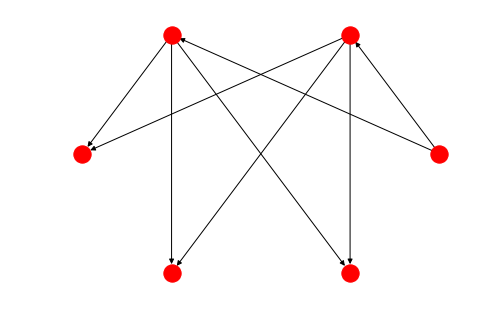

In [4]:
nx.draw_circular(g)

In [5]:
bottom_layer_shared_across_corpus = True

In [6]:
def all_paths(g, start=None, prefix=()):
    if start is None:
        start = g.graph["root"]
    assert nx.algorithms.is_directed_acyclic_graph(g)
    yield prefix
    node = convert_path_to_node(g, path = prefix)
    for c in nx.neighbors(g, node):
        for p in all_paths(g, start = c, prefix = prefix + (c,)):
            yield p

def depth(g):
    depths = set()
    for p in all_paths(g):
        if num_children(g, convert_path_to_node(g, p)) == 0:
            depths.add(len(p))
    assert len(depths) == 1
    return list(depths)[0]

def convert_path_to_node(g, path):
    if len(path) == 0:
        return g.graph["root"]
    else:
        return path[-1]

def num_children(g, node):
    return len(list(nx.neighbors(g, node)))

In [7]:
list(all_paths(g))

[(), (1,), (1, 3), (1, 4), (1, 5), (2,), (2, 3), (2, 4), (2, 5)]

In [8]:
depth(g)

2

In [9]:
m = bn.Model()
for node in g.nodes:
    nc = num_children(g, node)
    if nc == 0:
        m.add_random_variable(("alpha", node), bn.Constant(bn.Placeholder(shape=(bn.IndexSet("vocab"),))))
    else:
        m.add_random_variable(("alpha", node), bn.Constant(bn.Placeholder(shape=(nc,))))
documents_by_word_slot = bn.SymbolicMapping("word_slots", "documents", "documents_by_word_slot")

with m.loop_over("d", "documents") as d:
    for node in g.nodes:
        if num_children(g, node) > 0 or not bottom_layer_shared_across_corpus:
            m.add_random_variable(("theta", d, node), bn.Dirichlet(("alpha", node)))

if bottom_layer_shared_across_corpus:
    for node in g.nodes:
        if num_children(g, node) == 0:
            m.add_random_variable(("theta", node), bn.Dirichlet(("alpha", node)))

with m.loop_over("w", "word_slots") as w:
    m.add_random_variable(("current_doc", w), bn.Deterministic(documents_by_word_slot, args=[w]))
    #m.add_random_variable(("current_path", w, 0), bn.Constant((g.graph["root"],)))
    m.add_random_variable(("current_node", w, 0), bn.Constant(g.graph["root"]))
    for i in range(depth(g)):
        if i == depth(g) - 1 and bottom_layer_shared_across_corpus:
            m.add_random_variable(("current_theta", w, i), bn.DeterministicLookup("theta", indices=[("current_node", w, i)]))
        else:
            m.add_random_variable(("current_theta", w, i), bn.DeterministicLookup("theta", indices=[("current_doc", w), ("current_node", w, i)]))
        m.add_random_variable(("z", w, i), bn.Categorical(("current_theta", w, i)))
        m.add_random_variable(("current_node", w, i+1),
            bn.Deterministic(lambda x, y: sorted(list(nx.neighbors(g, x)))[y], args=[("current_node", w, i), ("z", w, i)]))
        #m.add_random_variable(("current_path", w, i+1),
        #    bn.Deterministic(lambda xs, x: xs + [x], args = [("current_path", w, i), ("current_node", w, i)]))
    m.add_random_variable(("current_theta", w, depth(g)), bn.DeterministicLookup("theta", indices=[("current_doc", w), ("current_node", w, depth(g))]))
    m.add_random_variable(("t", w), bn.Categorical(("current_theta", w, depth(g))))  # <-- observed data

In [10]:
m.vars_and_distribs

[(('alpha', 0), Constant(value=Placeholder(shape=(2,)))),
 (('alpha', 1), Constant(value=Placeholder(shape=(3,)))),
 (('alpha', 2), Constant(value=Placeholder(shape=(3,)))),
 (('alpha', 3), Constant(value=Placeholder(shape=(IndexSet(name='vocab'),)))),
 (('alpha', 4), Constant(value=Placeholder(shape=(IndexSet(name='vocab'),)))),
 (('alpha', 5), Constant(value=Placeholder(shape=(IndexSet(name='vocab'),)))),
 (('theta', for d in documents, 0), Dirichlet(alpha=('alpha', 0))),
 (('theta', for d in documents, 1), Dirichlet(alpha=('alpha', 1))),
 (('theta', for d in documents, 2), Dirichlet(alpha=('alpha', 2))),
 (('theta', 3), Dirichlet(alpha=('alpha', 3))),
 (('theta', 4), Dirichlet(alpha=('alpha', 4))),
 (('theta', 5), Dirichlet(alpha=('alpha', 5))),
 (('current_doc', for w in word_slots),
  Deterministic(func=SymbolicMapping(domain='word_slots', codomain='documents', name='documents_by_word_slot'), args=[for w in word_slots])),
 (('current_node', for w in word_slots, 0), Constant(value=

In [11]:
m = bn.Model()
m.add_random_variable(("foo",), bn.Constant(0))
with m.loop_over("a", "a_domain") as a:
    with m.loop_over("a2", "a_domain") as a2:
        m.add_random_variable(("bar", a, a2), bn.Constant(0))
    m.add_random_variable(("baz", a), bn.Constant(0))
print(m.vars_and_distribs)

[(('foo',), Constant(value=0)), (('bar', for a in a_domain, for a2 in a_domain), Constant(value=0)), (('baz', for a in a_domain), Constant(value=0))]


In [12]:
bn.DeterministicLookup("theta", indices=[("current_doc", w), ("current_node", w, 2)])

# equivalent to:

def lookup(var_collection, indices):
    result = var_collection
    for idx in indices:
        result = result[idx]
    return result

bn.Deterministic(lookup,
    args = [
        ("theta", bn.IndexSet("documents"), bn.IndexSet("nodes")),
        [("current_doc", w), ("current_node", w, 2)]
    ]
)

Deterministic(func=<function lookup at 0x109fb4158>, args=[('theta', IndexSet(name='documents'), IndexSet(name='nodes')), [('current_doc', for w in word_slots), ('current_node', for w in word_slots, 2)]])

In [13]:
# TODO

vocab_size = 8
vocab = ["w{:02}".format(i) for i in range(vocab_size)]

def docs_by_word_impl(w):
    num_long_docs = 2
    long_doc_size = 10
    short_doc_size = 5
    if w < num_long_docs * long_doc_size:
        return w // long_doc_size
    else:
        return num_long_docs + (w - num_long_docs * long_doc_size) // short_doc_size

m.generate_data(
    placeholders = {
        ("alpha", 0): np.ones(2),
        ("alpha", 1): np.ones(3),
        ("alpha", 2): np.ones(3),
        ("alpha", 3): np.ones(vocab_size),
        ("alpha", 4): np.ones(vocab_size),
        ("alpha", 5): np.ones(vocab_size),
    },
    sets = {
        "documents": np.arange(5),
        "word_slots": np.arange(25),
        "vocab": np.arange(vocab_size),
    },
    mappings = {
        "documents_by_word_slot": docs_by_word_impl,
    },
)

{}